In [1]:
%load_ext autoreload
%autoreload 2

# imports
import pandas as pd
import datetime

# data viz
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import sys, os
home_directory = '/home/matthew'
sys.path.append(home_directory+'/food-diary-analysis/lib')
from pipeline_components import pipeline_components as pc
from pipelines import pipelines as pipes


## Read in raw data

In [2]:
# read in full drop data
filepath = '../data/'
filename = 'test_data.csv'
raw_food_diary = pd.read_csv(filepath+filename, skiprows=1)

# double check data frame
raw_food_diary

,meal_ingredients,date,time,discomfort
0,"wheat, sugar, onion, garlic, chicken, peas, co...",April 18 2021,5:30 PM,3
1,"rice, sugar, garlic, roast, peas, carrot",April 20 2021,11:35 AM,4
2,"rice, sugar, garlic, roast, peas, carrot",April 21 2021,5:35 PM,4


In [3]:
raw_food_diary.dtypes

meal_ingredients    object
date                object
time                object
discomfort           int64
dtype: object

In [4]:
raw_food_diary.isnull().sum()

meal_ingredients    0
date                0
time                0
discomfort          0
dtype: int64

## Preliminary data cleanup pipeline

In [5]:
prelim_food_diary = raw_food_diary.copy()

In [6]:
pipeline = pipes.GenericPipeline(
    prelim_food_diary,
    [
        (
            pc.ConvertDateAndTimeToDatetime, 
            {}
        ),
        (
            pc.DropColumns,
            {"columns_to_drop": ['date', 'time']}
        )
    ]
)

In [7]:
prelim_food_diary = pipeline.run()

Starting to run pipeline...
Finished running pipeline...


In [8]:
prelim_food_diary

,meal_ingredients,discomfort,datetime
0,"wheat, sugar, onion, garlic, chicken, peas, co...",3,2021-04-18 17:30:00-04:00
1,"rice, sugar, garlic, roast, peas, carrot",4,2021-04-20 11:35:00-04:00
2,"rice, sugar, garlic, roast, peas, carrot",4,2021-04-21 17:35:00-04:00


## Preliminary data visualizations

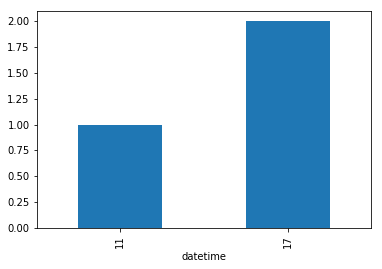

In [9]:
# histogram of meal times per hour
# TODO, maybe could make this better
# see: https://stackoverflow.com/questions/15478256/histogram-with-time-bins-from-datetime-vector
# and https://stackoverflow.com/questions/8369584/plot-histogram-of-datetime-time-python-matplotlib
(
    prelim_food_diary
    .drop(['meal_ingredients', 'discomfort'], axis=1)
    .groupby(prelim_food_diary["datetime"].dt.hour)
    .count()
    .plot(kind="bar", legend=False, xlim=[0, 24])
)

## Main pipeline

In [120]:
final_food_diary = prelim_food_diary.copy()
final_food_diary

,meal_ingredients,discomfort,datetime
0,"wheat, sugar, onion, garlic, chicken, peas, co...",3,2021-04-18 17:30:00-04:00
1,"rice, sugar, garlic, roast, peas, carrot",4,2021-04-20 11:35:00-04:00
2,"rice, sugar, garlic, roast, peas, carrot",4,2021-04-21 17:35:00-04:00


In [121]:
pipeline = pipes.GenericPipeline(
    final_food_diary,
    [
        (
            pc.ConvertStringColumnToListOfStrings,
            {"column_to_convert": "meal_ingredients"}
        ),
        (
            pc.ExplodeColumn,
            {"column_to_explode": "meal_ingredients"}
        ),
        (
            pc.RenameColumns,
            {"rename_map": {"meal_ingredients": "ingredient"}}
        ),
        (
            pc.CalculateMeanAndStdDevOfColumn,
            {
                "columns_to_groupby": ["ingredient"],
                "column_to_aggregate": "discomfort"
            }
        )
    ]
)

In [122]:
final_food_diary = pipeline.run()

Starting to run pipeline...
Finished running pipeline...


In [123]:
final_food_diary

,ingredient,discomfort_mean,discomfort_std,discomfort_count
0,carrot,4.000000,0.00000,2
1,chicken,3.000000,NaN,1
2,corn syrup,3.000000,NaN,1
3,garlic,3.666667,0.57735,3
4,lemon,3.000000,NaN,1
5,onion,3.000000,NaN,1
6,peas,3.666667,0.57735,3
7,rice,4.000000,0.00000,2
8,roast,4.000000,0.00000,2
9,sugar,3.666667,0.57735,3


In [ ]:

# TODO orderby component